## Step 1.1: Installing libraries, downloanding datasets + basic preprocessing.
We analyze datasets of (BTC, ETH, BNB) covering the last 730 days with a hourly frequency.

In [2]:
!pip -q install yfinance torch torchvision torchaudio pandas numpy matplotlib statsmodels

import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from IPython.display import clear_output
torch.manual_seed(42)
import torch
print("CUDA available:", torch.cuda.is_available())

CUDA available: True


In [3]:
TICKERS = ["BTC-USD", "ETH-USD", "BNB-USD"]
INTERVAL = "1h"
PERIOD = "730d"

def load_and_norm(ticker, period=PERIOD, interval=INTERVAL):
    df = yf.download(ticker, period=period, interval=interval)[["Close","Volume"]].dropna()
    if df.empty:
        print(f"[WARN] {ticker} misstake")
        return None
    df["LogRet"] = np.log(df["Close"]).diff()
    df = df.dropna()
    mu = df["LogRet"].median()
    mad = (df["LogRet"] - mu).abs().median()
    df["LogRetNorm"] = (df["LogRet"] - mu) / (mad + 1e-8)
    return df

data_dict = {}
for t in TICKERS:
    df = load_and_norm(t)
    if df is not None:
        data_dict[t] = df
        print(f"{t}: {df.shape[0]} strings")

print("Download:", len(data_dict))

/tmp/ipython-input-3850908879.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period=period, interval=interval)[["Close","Volume"]].dropna()
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3850908879.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period=period, interval=interval)[["Close","Volume"]].dropna()


BTC-USD: 17508 строк


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3850908879.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period=period, interval=interval)[["Close","Volume"]].dropna()


ETH-USD: 17507 строк


[*********************100%***********************]  1 of 1 completed

BNB-USD: 17508 строк
Загружено: 3 тикеров


## Step 1.2: Data Exploration and Plotting graphs
Let's visualize our datasets (BTC, ETH, BNB) to understand their properties:

- Price dynamics
- Log returns
- Distributions and fat tails
- Volatility clustering
- Correlations between assets

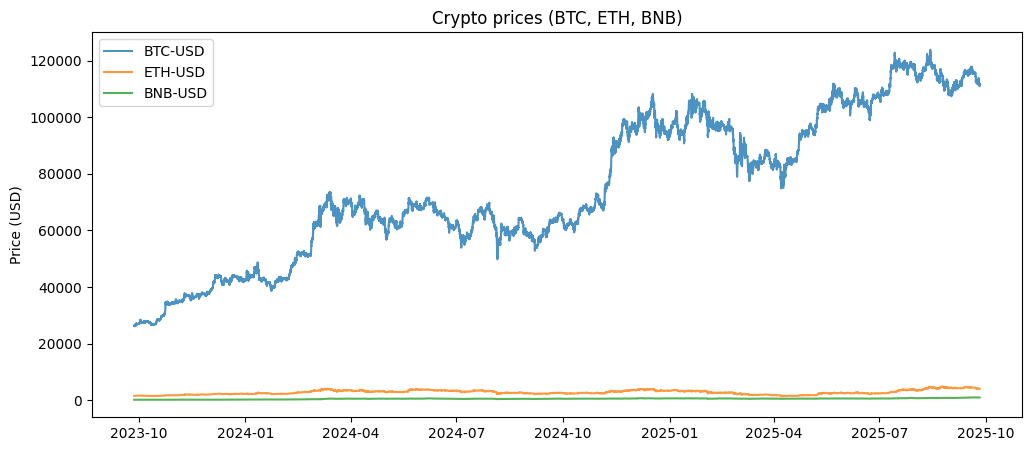

In [4]:
plt.figure(figsize=(12,5))
for t in data_dict:
    plt.plot(data_dict[t].index, data_dict[t]["Close"], label=t, alpha=0.8)
plt.legend(); plt.title("Crypto prices (BTC, ETH, BNB)")
plt.ylabel("Price (USD)")
plt.show()

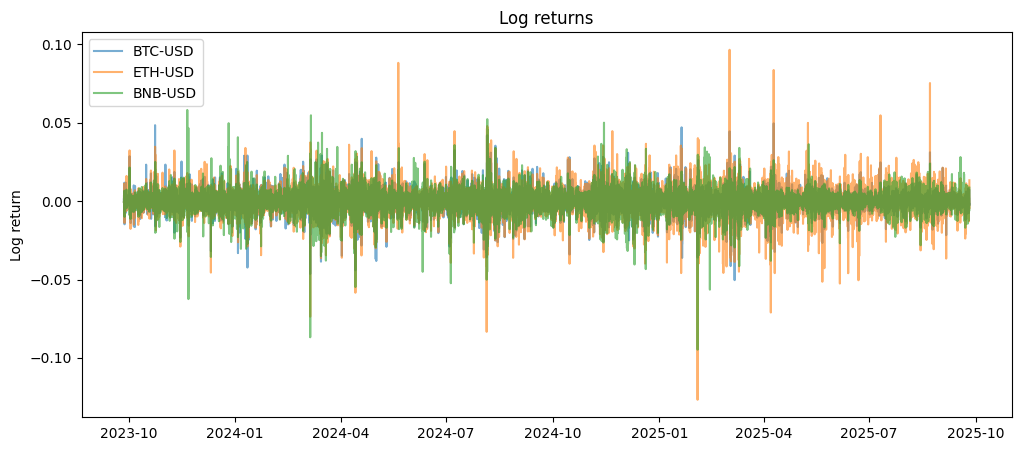

In [5]:
plt.figure(figsize=(12,5))
for t in data_dict:
    plt.plot(data_dict[t].index, data_dict[t]["LogRet"], label=t, alpha=0.6)
plt.legend(); plt.title("Log returns")
plt.ylabel("Log return")
plt.show()

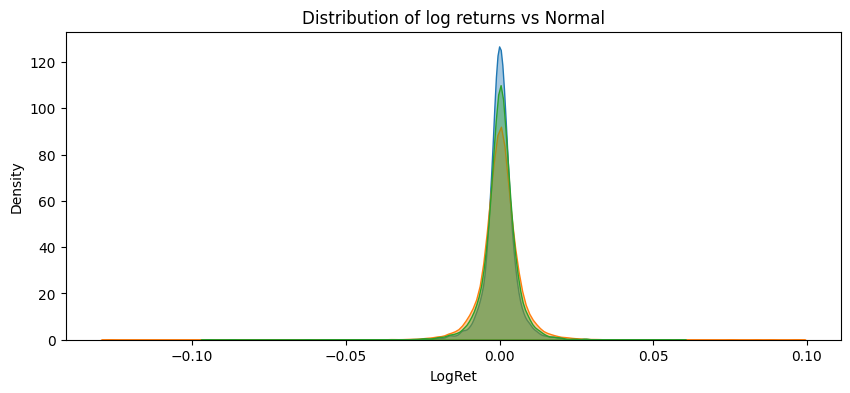

In [6]:
plt.figure(figsize=(10,4))
for t in data_dict:
    sns.kdeplot(data_dict[t]["LogRet"], label=t, fill=True, alpha=0.4)
plt.title("Distribution of log returns vs Normal")
plt.show()

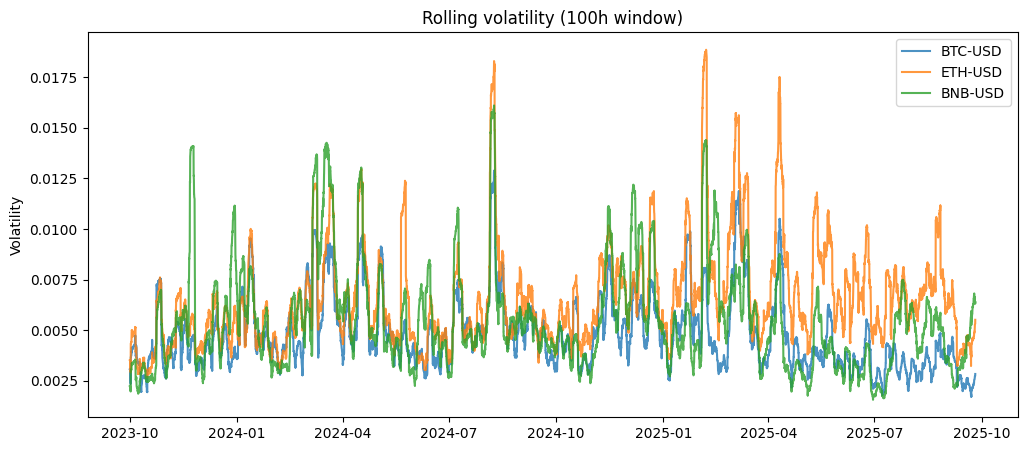

In [7]:
plt.figure(figsize=(12,5))
for t in data_dict:
    roll_std = data_dict[t]["LogRet"].rolling(100).std()
    plt.plot(roll_std, label=t, alpha=0.8)
plt.legend(); plt.title("Rolling volatility (100h window)")
plt.ylabel("Volatility")
plt.show()

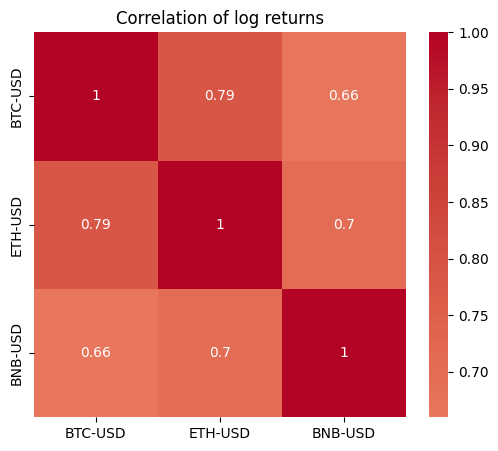

In [8]:
logrets = pd.concat([df["LogRet"] for df in data_dict.values()], axis=1)
logrets.columns = list(data_dict.keys())

plt.figure(figsize=(6,5))
sns.heatmap(logrets.corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Correlation of log returns")
plt.show()

## Step 1.3: Data Exploration and Stylized Facts

We now empirically check whether our crypto datasets (BTC, ETH, BNB) demonstrate
classic stylized facts of financial time series:

1. Fat tails in return distributions → high kurtosis compared to Normal.
2. Volatility clustering → autocorrelation of squared returns.
3. Asymmetry → skewness of return distribution.
4. Leverage effect → negative returns often imply higher future volatility.

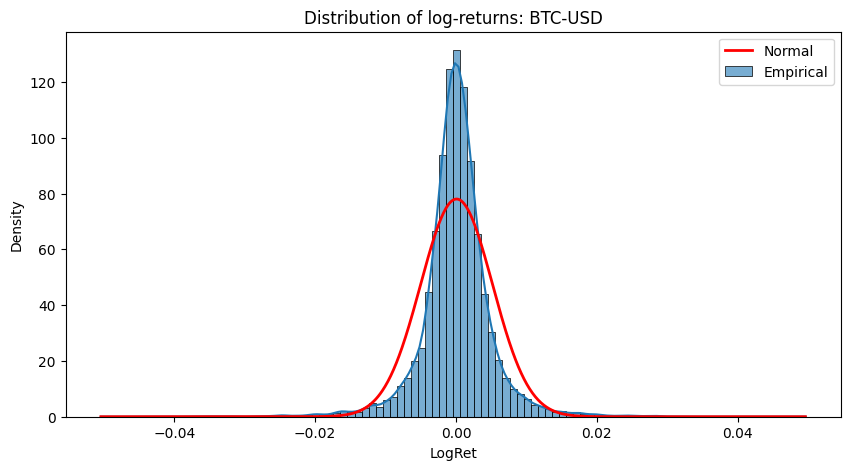

BTC-USD kurtosis = 10.41
→ Excess kurtosis > 3, distribution has fat tails (extreme events more frequent than Normal).


In [9]:
from scipy.stats import norm, kurtosis

asset = "BTC-USD"
rets = data_dict[asset]["LogRet"].dropna()

plt.figure(figsize=(10,5))
sns.histplot(rets, bins=100, kde=True, stat="density", alpha=0.6, label="Empirical")

mu, sigma = rets.mean(), rets.std()
x = np.linspace(rets.min(), rets.max(), 1000)
plt.plot(x, norm.pdf(x, mu, sigma), 'r', lw=2, label="Normal")
plt.title(f"Distribution of log-returns: {asset}")
plt.legend()
plt.show()

kurt = kurtosis(rets)
print(f"{asset} kurtosis = {kurt:.2f}")
if kurt > 3:
    print("→ Excess kurtosis > 3, distribution has fat tails (extreme events more frequent than Normal).")
else:
    print("→ Kurtosis close to Normal, no strong evidence of fat tails.")

In [10]:
from scipy.stats import skew

sk = skew(rets)
print(f"{asset} skewness = {sk:.2f}")
if sk < 0:
    print("→ Negative skewness: large negative returns are more frequent (left tail heavier).")
elif sk > 0:
    print("→ Positive skewness: large positive returns are more frequent (right tail heavier).")
else:
    print("→ Skewness near zero: distribution is symmetric.")

BTC-USD skewness = -0.13
→ Negative skewness: large negative returns are more frequent (left tail heavier).


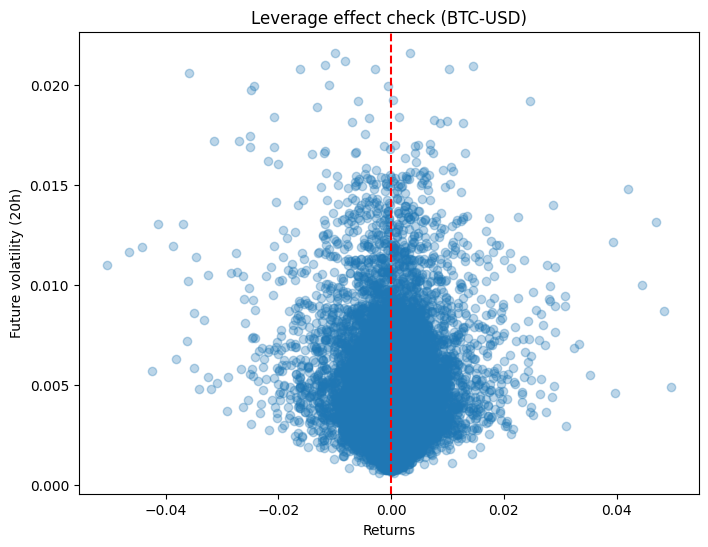

If negative returns are associated with higher future volatility → leverage effect is observed.


In [11]:
future_vol = rets.rolling(20).std().shift(-20)

plt.figure(figsize=(8,6))
plt.scatter(rets, future_vol, alpha=0.3)
plt.xlabel("Returns")
plt.ylabel("Future volatility (20h)")
plt.title(f"Leverage effect check ({asset})")
plt.axvline(0, color="red", linestyle="--")
plt.show()

print("If negative returns are associated with higher future volatility → leverage effect is observed.")

## Step 1.4: Data preparation for GAN
- Formation of training windows of fixed lengh (64)
- Constracting dataset and DaataLoader
- Verefication of dataset size

In [12]:
SEQ_LEN = 64

class MultiTSWindows(Dataset):
    def __init__(self, series_list, seq_len=64):
        self.samples = []
        for s in series_list:
            x = s.astype(np.float32).values
            idx = np.arange(len(x) - seq_len)
            for i in idx:
                self.samples.append(torch.from_numpy(x[i:i+seq_len]).unsqueeze(0))  # [1,L]
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, i):
        return self.samples[i]


series_list = [df["LogRetNorm"] for df in data_dict.values()]

dataset = MultiTSWindows(series_list, SEQ_LEN)
loader = DataLoader(dataset, batch_size=128, shuffle=True, drop_last=True)

print("Всего окон в датасете:", len(dataset))

Всего окон в датасете: 52331


## Step 2: GAN
2.1: Implement GAN (with an LTSM-based generator and 1D-CNN discriminator)

In [13]:
LATENT_DIM = 32
HIDDEN = 64

class Generator(nn.Module):
    def __init__(self, z_dim=32, seq_len=64, hidden=64):
        super().__init__()
        self.seq_len = seq_len
        self.fc = nn.Sequential(
            nn.Linear(z_dim, hidden*seq_len),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.rnn = nn.LSTM(input_size=hidden, hidden_size=hidden, num_layers=1, batch_first=True)
        self.out = nn.Linear(hidden, 1)

    def forward(self, z):
        # z: [B, z_dim]
        h = self.fc(z)                          # [B, hidden*L]
        h = h.view(z.size(0), self.seq_len, -1) # [B, L, hidden]
        h,_ = self.rnn(h)
        x = self.out(h).squeeze(-1)             # [B, L]
        return x.unsqueeze(1)        # [-1..1], shape [B,1,L]

class Discriminator(nn.Module):
    def __init__(self, seq_len=64, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(1, 32, 5, padding=2), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(32, 64, 5, padding=2), nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(64*seq_len, hidden), nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden, 1),
            nn.Sigmoid()
        )
    def forward(self, x):  # x: [B,1,L]
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
G = Generator(LATENT_DIM, SEQ_LEN, HIDDEN).to(device)
D = Discriminator(SEQ_LEN, HIDDEN).to(device)

bce = nn.BCELoss()
optG = torch.optim.Adam(G.parameters(), lr=1e-4, betas=(0.5, 0.999))
optD = torch.optim.Adam(D.parameters(), lr=5e-5, betas=(0.5, 0.999))

Step 2.2: Learning

Epoch 200/200 | D: 1.211 | G: 0.918


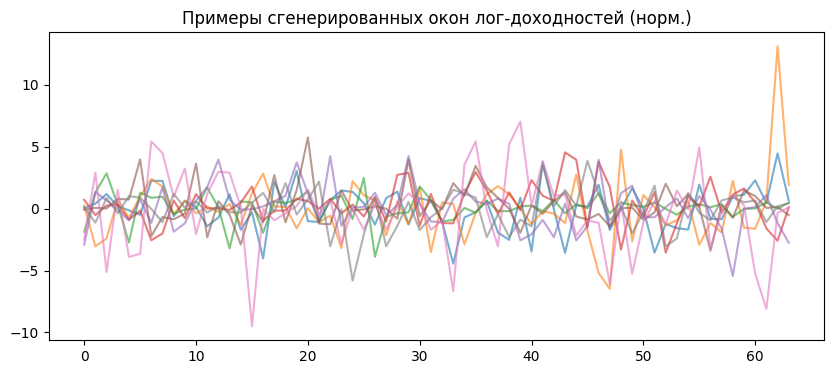

In [14]:
EPOCHS = 200

for epoch in range(1, EPOCHS+1):
    Dl, Gl = 0.0, 0.0
    for real in loader:
        real = real.cuda()  # [B,1,L]
        B = real.size(0)

        # --- Train D ---
        z = torch.randn(B, LATENT_DIM, device=real.device)
        fake = G(z).detach()
        pred_real = D(real)
        pred_fake = D(fake)
        lossD = bce(pred_real, torch.ones_like(pred_real)) + \
                bce(pred_fake, torch.zeros_like(pred_fake))
        optD.zero_grad(); lossD.backward(); optD.step()

        # --- Train G ---
        z = torch.randn(B, LATENT_DIM, device=real.device)
        fake = G(z)
        pred = D(fake)
        lossG = bce(pred, torch.ones_like(pred))
        optG.zero_grad(); lossG.backward(); optG.step()

        Dl += lossD.item(); Gl += lossG.item()

    clear_output(wait=True)
    print(f"Epoch {epoch}/{EPOCHS} | D: {Dl/len(loader):.3f} | G: {Gl/len(loader):.3f}")

#
G.eval()
with torch.no_grad():
    gen = G(torch.randn(8, LATENT_DIM).cuda()).cpu().squeeze(1).numpy()
plt.figure(figsize=(10,4))
for i in range(8):
    plt.plot(gen[i], alpha=0.6)
plt.title("Examples of generated log-yield windows"); plt.show()

Realization TimeGan

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Embedder(nn.Module):
    def __init__(self, x_dim=1, h_dim=24, num_layers=1):
        super().__init__()
        self.rnn = nn.GRU(x_dim, h_dim, num_layers=num_layers, batch_first=True)
        self.proj = nn.Linear(h_dim, h_dim)
    def forward(self, x):                      # x: [B, L, x_dim]
        h, _ = self.rnn(x)
        return self.proj(h)                    # H: [B, L, h_dim]

class Recovery(nn.Module):
    def __init__(self, h_dim=24, x_dim=1, num_layers=1):
        super().__init__()
        self.rnn = nn.GRU(h_dim, h_dim, num_layers=num_layers, batch_first=True)
        self.proj = nn.Linear(h_dim, x_dim)
    def forward(self, h):                      # h: [B, L, h_dim]
        y, _ = self.rnn(h)
        return self.proj(y)                    # X~: [B, L, x_dim]

class GeneratorZ(nn.Module):
    def __init__(self, z_dim=16, h_dim=24, num_layers=1):
        super().__init__()
        self.rnn = nn.GRU(z_dim, h_dim, num_layers=num_layers, batch_first=True)
        self.proj = nn.Linear(h_dim, h_dim)
    def forward(self, z):                      # z: [B, L, z_dim]
        h, _ = self.rnn(z)
        return self.proj(h)                    # H_tilde

class Supervisor(nn.Module):
    def __init__(self, h_dim=24, num_layers=1):
        super().__init__()
        self.rnn = nn.GRU(h_dim, h_dim, num_layers=num_layers, batch_first=True)
        self.proj = nn.Linear(h_dim, h_dim)
    def forward(self, h):
        y, _ = self.rnn(h)
        return self.proj(y)                    # \hat{H}

class DiscriminatorT(nn.Module):
    def __init__(self, h_dim=24, num_layers=1):
        super().__init__()
        self.rnn = nn.GRU(h_dim, h_dim, num_layers=num_layers, batch_first=True)
        self.proj = nn.Linear(h_dim, 1)
    def forward(self, h):                      # h: [B, L, h_dim]
        y, _ = self.rnn(h)
        logits = self.proj(y)                  # [B, L, 1]
        return logits.mean(dim=1)              #  -> [B, 1]

class TimeGAN(nn.Module):
    def __init__(self, x_dim=1, z_dim=16, h_dim=24):
        super().__init__()
        self.E = Embedder(x_dim, h_dim)
        self.R = Recovery(h_dim, x_dim)
        self.G = GeneratorZ(z_dim, h_dim)
        self.S = Supervisor(h_dim)
        self.D = DiscriminatorT(h_dim)


    def embed(self, x):         # X -> H
        return self.E(x)
    def recover(self, h):       # H -> X~
        return self.R(h)
    def gen_hidden(self, z):    # Z -> H_tilde
        return self.G(z)
    def sup(self, h):           # H / H_tilde -> \hat{H}
        return self.S(h)

    # main generation (x)
    def generate(self, z):      # [B, L, z_dim] -> [B, L, x_dim]
        h_tilde = self.gen_hidden(z)
        h_hat   = self.sup(h_tilde)
        x_hat   = self.recover(h_hat)
        return x_hat

# hyperparameters of TimeGAN
Z_DIM_TG = 16
H_DIM_TG = 24
timegan = TimeGAN(x_dim=1, z_dim=Z_DIM_TG, h_dim=H_DIM_TG).to(device)

# loss/optimizers
bce = nn.BCEWithLogitsLoss()
mse = nn.MSELoss()

opt_E = torch.optim.Adam(timegan.E.parameters(), lr=1e-3)
opt_R = torch.optim.Adam(timegan.R.parameters(), lr=1e-3)
opt_GS = torch.optim.Adam(list(timegan.G.parameters()) + list(timegan.S.parameters()), lr=1e-4, betas=(0.5,0.999))
opt_D  = torch.optim.Adam(timegan.D.parameters(), lr=5e-5, betas=(0.5,0.999))

def to_seq(batch_1L):  # твоё окно: [B,1,L] -> [B,L,1]
    return batch_1L.permute(0,2,1).contiguous().float()

2/3 тренировка TimeGAN

In [16]:
from tqdm.auto import tqdm
import math

# 1) Pretrain: autoencoder (E+R) by MSE
PRE_EPOCHS_AE = 20
for ep in tqdm(range(PRE_EPOCHS_AE), desc="Pretrain E+R (AE)"):
    timegan.train()
    loss_sum = 0.0
    for real in loader:                             # real: [B,1,L]
        x = to_seq(real.to(device))                 # [B,L,1]
        H = timegan.embed(x)
        x_tilde = timegan.recover(H)
        loss_ae = mse(x_tilde, x)
        opt_E.zero_grad(); opt_R.zero_grad()
        loss_ae.backward()
        opt_E.step(); opt_R.step()
        loss_sum += float(loss_ae.item())
    # print(f"AE {ep+1}: {loss_sum/len(loader):.4f}")

# 2) Pretrain: Supervisor (S) — learn predict H(t+1) by H(t)
PRE_EPOCHS_S = 20
for ep in tqdm(range(PRE_EPOCHS_S), desc="Pretrain Supervisor"):
    timegan.train()
    loss_sum = 0.0
    for real in loader:
        x = to_seq(real.to(device))
        H = timegan.embed(x).detach()               # H: [B,L,h]
        H_hat = timegan.sup(H)
        # сдвиг по времени: H[1:] ~ H_hat[:-1]
        loss_s = mse(H[:,1:,:], H_hat[:,:-1,:])
        opt_GS.zero_grad()
        loss_s.backward()
        opt_GS.step()
        loss_sum += float(loss_s.item())

# 3) Joint training: G+S against D
EPOCHS_JOINT = 100
lambda_sup = 0.1
lambda_ae  = 10.0
lambda_mom = 1.0

for ep in tqdm(range(EPOCHS_JOINT), desc="Joint training"):
    Dl, Gl = 0.0, 0.0
    for real in loader:
        x = to_seq(real.to(device))                 # [B,L,1]

        # ---- Discriminator ----
        H_real = timegan.embed(x).detach()          # [B,L,h]
        z = torch.randn(x.size(0), x.size(1), Z_DIM_TG, device=device)
        H_tilde = timegan.gen_hidden(z).detach()
        H_hat   = timegan.sup(H_tilde).detach()

        logits_real = timegan.D(H_real)
        logits_fake = timegan.D(H_hat)

        loss_D = bce(logits_real, torch.ones_like(logits_real)) + \
                 bce(logits_fake, torch.zeros_like(logits_fake))
        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()
        Dl += float(loss_D.item())

        # ---- Generator + Supervisor ----
        z = torch.randn(x.size(0), x.size(1), Z_DIM_TG, device=device)
        H_tilde = timegan.gen_hidden(z)
        H_hat   = timegan.sup(H_tilde)

        logits_fake = timegan.D(H_hat)
        loss_G_adv  = bce(logits_fake, torch.ones_like(logits_fake))

        H_real = timegan.embed(x).detach()
        loss_G_sup = mse(H_real[:,1:,:], timegan.sup(H_real)[:,:-1,:])

        x_hat = timegan.recover(H_hat)
        def moments(y):
            m = y.mean(dim=(0,1), keepdim=True); s = y.std(dim=(0,1), keepdim=True) + 1e-6
            return m, s
        m_x, s_x = moments(x)
        m_g, s_g = moments(x_hat)
        loss_mom = mse(m_g, m_x) + mse(s_g, s_x)

        loss_G = loss_G_adv + lambda_sup*loss_G_sup + lambda_mom*loss_mom
        opt_GS.zero_grad()
        loss_G.backward()
        opt_GS.step()
        Gl += float(loss_G.item())

        H = timegan.embed(x)
        x_tilde = timegan.recover(H)
        loss_ER = lambda_ae * mse(x_tilde, x) + lambda_sup * mse(H[:,1:,:], timegan.sup(H)[:,:-1,:])
        opt_E.zero_grad(); opt_R.zero_grad()
        loss_ER.backward()
        opt_E.step(); opt_R.step()

    # print(f"Joint {ep+1}/{EPOCHS_JOINT} | D: {Dl/len(loader):.3f} | G: {Gl/len(loader):.3f}")

Pretrain E+R (AE):   0%|          | 0/20 [00:00<?, ?it/s]

Pretrain Supervisor:   0%|          | 0/20 [00:00<?, ?it/s]

Joint training:   0%|          | 0/100 [00:00<?, ?it/s]

In [17]:
# !pip -q install scikit-learn

import numpy as np
import pandas as pd
import torch
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (explained_variance_score, max_error,
                             mean_absolute_error, mean_squared_error,
                             mean_squared_log_error, median_absolute_error,
                             r2_score)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def collect_real_windows_from_dataset(dataset, max_windows=None):
    n = len(dataset) if max_windows is None else min(len(dataset), max_windows)
    X = torch.stack([dataset[i] for i in range(n)], dim=0).cpu().numpy()  # (N,1,L)
    if X.ndim == 3:  # (N,1,L) -> (N,L)
        X = X[:, 0, :]
    return X

def gen_windows_from_G(G, n, latent_dim):
    G.eval()
    outs = []
    with torch.no_grad():
        k = 0
        bs = 512
        while k < n:
            b = min(bs, n-k)
            z = torch.randn(b, latent_dim, device=device)
            y = G(z).detach().cpu().numpy()   # (b,1,L) или (b,L)
            if y.ndim == 3: y = y[:, 0, :]
            outs.append(y); k += b
    return np.vstack(outs)

def make_xy(windows):
    return windows[:, :-1], windows[:, -1]

def safe_msle(y_true, y_pred, eps=1e-9):
    shift = max(0.0, -float(np.min([y_true.min(), y_pred.min()]))) + eps
    return mean_squared_log_error(y_true + shift, y_pred + shift)

def metrics_table(y_true, y_pred):
    return dict(
        explained_variance      = explained_variance_score(y_true, y_pred),
        max_error               = max_error(y_true, y_pred),
        mean_absolute_error     = mean_absolute_error(y_true, y_pred),
        mean_squared_error      = mean_squared_error(y_true, y_pred),
        mean_squared_log_error  = safe_msle(y_true, y_pred),
        median_absolute_error   = median_absolute_error(y_true, y_pred),
        r2_score                = r2_score(y_true, y_pred),
    )

def train_and_eval(X_train, y_train, X_test, y_test, scale_y=False):
    Xsc = StandardScaler().fit(X_train)
    Xtr = Xsc.transform(X_train)
    Xte = Xsc.transform(X_test)

    if scale_y:
        Ysc = StandardScaler().fit(y_train.reshape(-1,1))
        ytr = Ysc.transform(y_train.reshape(-1,1)).ravel()
    else:
        ytr = y_train

    model = RidgeCV(alphas=(1e-3,1e-2,1e-1,1,10,100))
    model.fit(Xtr, ytr)
    yhat = model.predict(Xte)

    if scale_y:
        yhat = Ysc.inverse_transform(yhat.reshape(-1,1)).ravel()

    return yhat

In [18]:

real_windows = collect_real_windows_from_dataset(dataset)  # (N, L)
N, L = real_windows.shape
print(f"Real windows: {real_windows.shape}")

# 2) train/test (80/20).
split = int(0.8 * N)
win_train, win_test = real_windows[:split], real_windows[split:]
X_train_real, y_train_real = make_xy(win_train)
X_test_real,  y_test_real  = make_xy(win_test)


MODELS = {
    "original":  lambda n: win_train[:n],                         # real train
    "gan":  lambda n: gen_windows_from_G(G, n, LATENT_DIM),  # syntetic
}

rows = {}

# 4) baseline "previous_day" = last window value
yhat_prev = X_test_real[:, -1]
rows["previous_day"] = metrics_table(y_test_real, yhat_prev)

# 5)
for name, gen_fn in MODELS.items():
    syn_train = gen_fn(len(win_train))          # (N_train, L)
    if syn_train.shape[1] != L:
        syn_train = syn_train[:, :L]
    X_train_syn, y_train_syn = make_xy(syn_train)

    yhat = train_and_eval(X_train_syn, y_train_syn, X_test_real, y_test_real, scale_y=False)
    rows[name] = metrics_table(y_test_real, yhat)

order = ["explained_variance", "max_error",
         "mean_absolute_error", "mean_squared_error",
         "mean_squared_log_error", "median_absolute_error", "r2_score"]

cols = list(MODELS.keys()) + ["previous_day"]
df = pd.DataFrame({k: {m: rows[k][m] for m in order} for k in cols})
display(df.round(6))

Real windows: (52331, 64)


,original,gan,previous_day
explained_variance,0.001124,-0.030871,-1.012976
max_error,37.877058,37.558565,38.335285
mean_absolute_error,1.486249,1.526752,2.156618
mean_squared_error,5.176035,5.347434,10.427247
mean_squared_log_error,0.004859,0.004972,0.009474
median_absolute_error,0.991743,1.025519,1.455725
r2_score,0.000768,-0.032320,-1.012976


In [19]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import (explained_variance_score, max_error,
                             mean_absolute_error, mean_squared_error,
                             mean_squared_log_error, median_absolute_error,
                             r2_score)
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def ensure_3d(arr):
    arr = np.asarray(arr)
    if arr.ndim == 2:   # (N, L) -> (N,1,L)
        arr = arr[:, None, :]
    return arr

def collect_real_windows_from_loader(loader, max_windows=2000):
    xs = []
    for real, *_ in loader:
        xs.append(real.detach().cpu().numpy())
        if sum(x.shape[0] for x in xs) >= max_windows:
            break
    X = np.concatenate(xs, axis=0)[:max_windows]  # (N,1,L) обычно
    return X

def generate_synthetic_windows(G, n, latent_dim, batch_size=256):
    G.eval()
    out = []
    with torch.no_grad():
        k = 0
        while k < n:
            b = min(batch_size, n - k)
            z = torch.randn(b, latent_dim, device=device)
            y = G(z).detach().cpu().numpy()   # ожидаем (b,1,L)
            out.append(y)
            k += b
    return np.concatenate(out, axis=0)

def acf_with_ci(series_1d, nlags=40, alpha=0.05):
    acf_vals, confint = sm.tsa.stattools.acf(series_1d, nlags=nlags, fft=True, alpha=alpha)
    lags = np.arange(len(acf_vals))
    return lags, acf_vals, confint

def corr_matrix_dataset(X):
    # X: (N,F,L)
    N,F,L = X.shape
    if F > 1:
        A = X.transpose(1,0,2).reshape(F, -1)    # (F, N*L)
        M = np.corrcoef(A)
        labels = [f"f{j}" for j in range(F)]
    else:
        A = X[:,0,:]                              # (N,L)
        M = np.corrcoef(A, rowvar=False)          # (L,L)
        labels = [f"t{j}" for j in range(L)]
    return M, labels

def tsne_embed(X_real, X_syn, max_per_class=1000, rs=42):
    R = X_real.reshape(X_real.shape[0], -1)
    S = X_syn.reshape(X_syn.shape[0], -1)
    n = int(min(len(R), len(S), max_per_class))
    rng = np.random.default_rng(rs)
    ridx = rng.choice(len(R), n, replace=False)
    sidx = rng.choice(len(S), n, replace=False)
    RS = np.vstack([R[ridx], S[sidx]])
    y = np.array([0]*n + [1]*n)
    RS = StandardScaler().fit_transform(RS)
    emb = TSNE(n_components=2, init="pca", learning_rate="auto",
               perplexity=max(5, min(30, n-1)), random_state=rs).fit_transform(RS)
    return emb, y

def safe_msle(y_true, y_pred, eps=1e-9):
    mn = min(float(np.min(y_true)), float(np.min(y_pred)))
    shift = (-mn + eps) if mn < 0 else 0.0
    return mean_squared_log_error(y_true + shift, y_pred + shift)

def pairwise_metrics_bidirectional(X_real, X_syn):
    Rf = X_real.reshape(len(X_real), -1)
    Sf = X_syn.reshape(len(X_syn), -1)

    nn_R = NearestNeighbors(n_neighbors=1).fit(Rf)
    _, idx_sr = nn_R.kneighbors(Sf)
    y_true_sr = Rf[idx_sr[:,0]].reshape(-1)
    y_pred_sr = Sf.reshape(-1)

    nn_S = NearestNeighbors(n_neighbors=1).fit(Sf)
    _, idx_rs = nn_S.kneighbors(Rf)
    y_true_rs = Rf.reshape(-1)
    y_pred_rs = Sf[idx_rs[:,0]].reshape(-1)

    def pack(y_true, y_pred):
        return dict(
            explained_variance = explained_variance_score(y_true, y_pred),
            max_error           = max_error(y_true, y_pred),
            mae                 = mean_absolute_error(y_true, y_pred),
            mse                 = mean_squared_error(y_true, y_pred),
            msle                = safe_msle(y_true, y_pred),
            median_ae           = median_absolute_error(y_true, y_pred),
            r2                  = r2_score(y_true, y_pred),
        )

    m1, m2 = pack(y_true_sr, y_pred_sr), pack(y_true_rs, y_pred_rs)
    return {k:(m1[k]+m2[k])/2 for k in m1}

Real windows: (408, 1, 64)
Synthetic windows: (408, 1, 64)


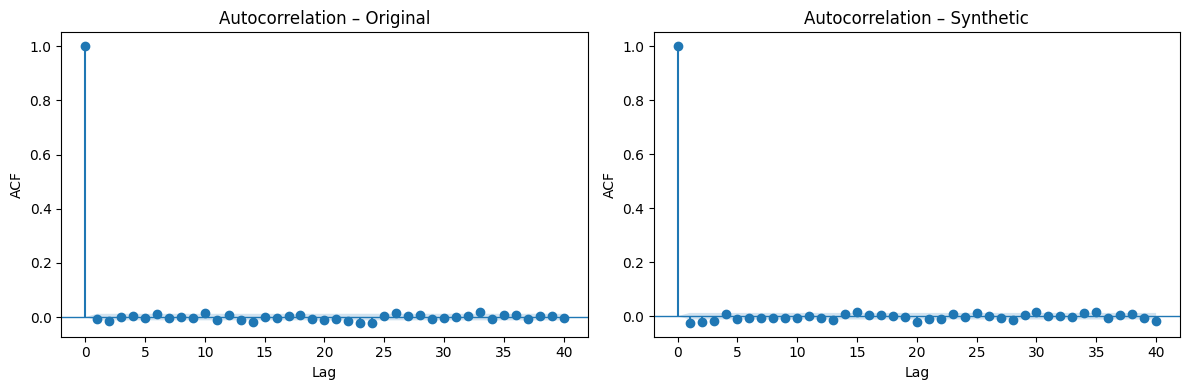

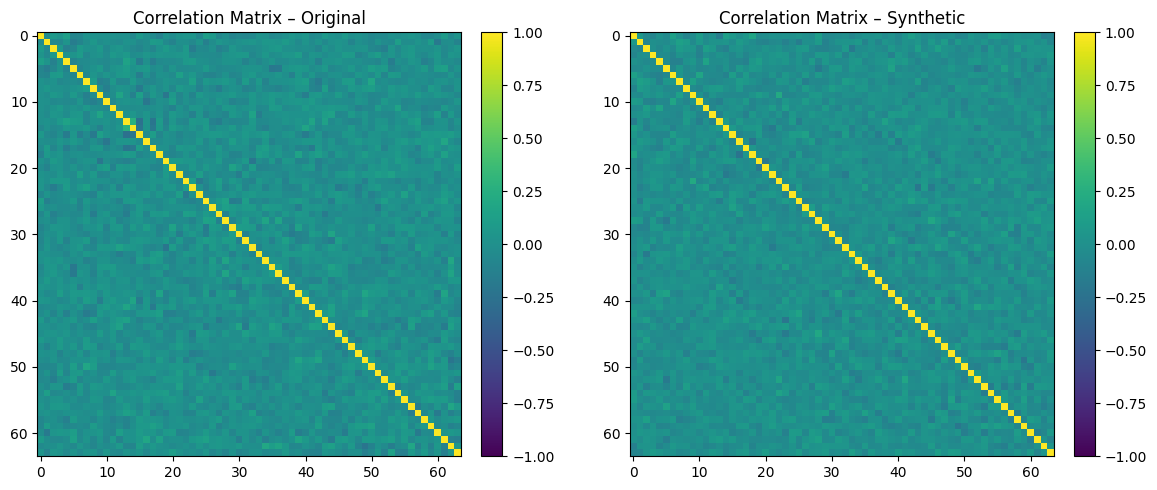

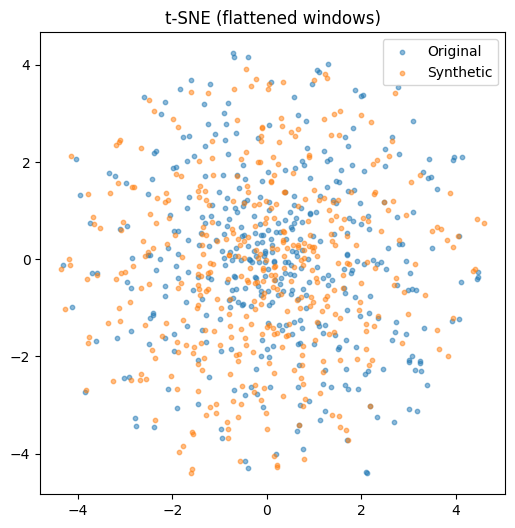

,value
explained_variance,-1.156959
max_error,21.904587
mae,1.446583
mse,4.147951
msle,0.010324
median_ae,1.054135
r2,-1.159452


In [20]:
MAX_WINDOWS = 2000
ACF_LAGS    = 40
FEAT_FOR_ACF = 0

real_np = collect_real_windows_from_loader(loader, max_windows=MAX_WINDOWS)  # (N,1,L) usual
real_np = ensure_3d(real_np)
N, C, L = real_np.shape
print("Real windows:", real_np.shape)

syn_np  = generate_synthetic_windows(G, n=N, latent_dim=LATENT_DIM)
syn_np  = ensure_3d(syn_np)[:, :C, :L]
print("Synthetic windows:", syn_np.shape)

Xr = ensure_3d(real_np)
Xs = ensure_3d(syn_np)

# ==== 1) Autocorrelation (Original vs Synthetic) ====
# ==== 1) Autocorrelation (Original vs Synthetic) ====
r_long = Xr[:, FEAT_FOR_ACF, :].reshape(-1)
s_long = Xs[:, FEAT_FOR_ACF, :].reshape(-1)
lags_r, acf_r, ci_r = acf_with_ci(r_long, nlags=ACF_LAGS)
lags_s, acf_s, ci_s = acf_with_ci(s_long, nlags=ACF_LAGS)

def plot_acf(ax, lags, acf, ci, title):
    ci0, ci1 = ci[:, 0] - acf, ci[:, 1] - acf

    markerline, stemlines, baseline = ax.stem(lags, acf)  # <- without use_line_collection
    plt.setp(baseline, visible=False)
    ax.fill_between(lags, ci0, ci1, alpha=0.2)
    ax.axhline(0, linewidth=1)
    ax.set_title(title)
    ax.set_xlabel("Lag"); ax.set_ylabel("ACF")

plt.figure(figsize=(12, 4))
plot_acf(plt.subplot(1,2,1), lags_r, acf_r, ci_r, "Autocorrelation – Original")
plot_acf(plt.subplot(1,2,2), lags_s, acf_s, ci_s, "Autocorrelation – Synthetic")
plt.tight_layout(); plt.show()


# Correlation Matrix
CM_r, labels_r = corr_matrix_dataset(Xr)
CM_s, labels_s = corr_matrix_dataset(Xs)

fig, axes = plt.subplots(1,2, figsize=(12,5))
im0 = axes[0].imshow(CM_r, vmin=-1, vmax=1)
axes[0].set_title("Correlation Matrix – Original")
fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

im1 = axes[1].imshow(CM_s, vmin=-1, vmax=1)
axes[1].set_title("Correlation Matrix – Synthetic")
fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

# t-SNE
emb, y = TSNE(n_components=2, init="pca", learning_rate="auto",
              perplexity=max(5, min(30, min(len(Xr), len(Xs)) - 1)),
              random_state=42).fit_transform(
    StandardScaler().fit_transform(
        np.vstack([Xr.reshape(len(Xr), -1), Xs.reshape(len(Xs), -1)])
    )
), np.array([0]*len(Xr) + [1]*len(Xs))

plt.figure(figsize=(6,6))
plt.scatter(emb[y==0,0], emb[y==0,1], alpha=0.5, label="Original", s=10)
plt.scatter(emb[y==1,0], emb[y==1,1], alpha=0.5, label="Synthetic", s=10)
plt.title("t-SNE (flattened windows)")
plt.legend()
plt.show()

#  NN-pairing, двунаправленно
metrics = pairwise_metrics_bidirectional(Xr, Xs)
df_metrics = pd.DataFrame([metrics]).T
df_metrics.columns = ["value"]
display(df_metrics.round(6))

TimeGan 3/3

In [21]:
import numpy as np
import pandas as pd

def gen_windows_from_TimeGAN(model, n, seq_len=SEQ_LEN):
    model.eval()
    out = []
    with torch.no_grad():
        bs = 512
        k = 0
        while k < n:
            b = min(bs, n-k)
            z = torch.randn(b, seq_len, Z_DIM_TG, device=device)
            x_hat = model.generate(z)                   # [B,L,1]
            out.append(x_hat.squeeze(-1).cpu().numpy()) # -> (B,L)
            k += b
    return np.vstack(out)


if 'win_train' not in globals():
    real_windows = torch.stack([dataset[i] for i in range(len(dataset))], dim=0).cpu().numpy()[:,0,:]
    N, L = real_windows.shape
    split = int(0.8*N)
    win_train, win_test = real_windows[:split], real_windows[split:]
    X_train_real, y_train_real = win_train[:,:-1], win_train[:,-1]
    X_test_real,  y_test_real  = win_test[:,:-1],  win_test[:,-1]

MODELS.update({
    "time_gan": lambda n: gen_windows_from_TimeGAN(timegan, n, seq_len=SEQ_LEN)
})

rows = {}

yhat_prev = X_test_real[:, -1]
rows["previous_day"] = metrics_table(y_test_real, yhat_prev)

for name, gen_fn in MODELS.items():
    syn_train = gen_fn(len(win_train))       # (N_train, L)
    syn_train = syn_train[:, :L]
    X_tr, y_tr = syn_train[:,:-1], syn_train[:,-1]
    yhat = train_and_eval(X_tr, y_tr, X_test_real, y_test_real, scale_y=False)
    rows[name] = metrics_table(y_test_real, yhat)

order = ["explained_variance","max_error","mean_absolute_error","mean_squared_error",
         "mean_squared_log_error","median_absolute_error","r2_score"]
cols = list(MODELS.keys()) + ["previous_day"]
df_timegan = pd.DataFrame({k: {m: rows[k][m] for m in order} for k in cols}).round(6)
display(df_timegan)

,original,gan,time_gan,previous_day
explained_variance,0.001124,-0.032692,-0.013051,-1.012976
max_error,37.877058,37.574232,38.960234,38.335285
mean_absolute_error,1.486249,1.526011,1.489964,2.156618
mean_squared_error,5.176035,5.355163,5.295817,10.427247
mean_squared_log_error,0.004859,0.004980,0.004977,0.009474
median_absolute_error,0.991743,1.022538,0.981040,1.455725
r2_score,0.000768,-0.033812,-0.022356,-1.012976


In [35]:
#MTSS-GAN
import torch, torch.nn as nn
import torch.nn.functional as F

class ResDilBlock(nn.Module):
    def __init__(self, ch, dilation=1, ks=3):
        super().__init__()
        pad = (ks-1)//2 * dilation
        self.conv1 = nn.Conv1d(ch, ch, ks, padding=pad, dilation=dilation)
        self.conv2 = nn.Conv1d(ch, ch, ks, padding=pad, dilation=dilation)
        self.act = nn.LeakyReLU(0.2)
        nn.init.kaiming_normal_(self.conv1.weight)
        nn.init.kaiming_normal_(self.conv2.weight)

    def forward(self, x):
        h = self.act(self.conv1(x))
        h = self.conv2(h)
        return self.act(h + x)


class MTSSGenerator(nn.Module):
    def __init__(self, z_dim=32, seq_len=64, ch=64, dilations=(1,2,4,8)):
        super().__init__()
        self.seq_len = seq_len
        self.fc = nn.Linear(z_dim, ch*seq_len)
        self.blocks = nn.ModuleList([ResDilBlock(ch, d) for d in dilations for _ in (0,1)])
        self.out = nn.Conv1d(ch, 1, 1)
        self.act = nn.LeakyReLU(0.2)

        nn.init.xavier_normal_(self.fc.weight)
        nn.init.xavier_normal_(self.out.weight)
        self.out.weight.data *= 0.01
        if self.out.bias is not None:
            self.out.bias.data.zero_()

    def forward(self, z):             # z: [B, z_dim]
        h = self.fc(z).view(z.size(0), -1, self.seq_len)  # [B, ch, L]
        for blk in self.blocks:
            h = blk(h)
        x = self.out(self.act(h))
        return x

from torch.nn.utils import spectral_norm as SN

class DBranch(nn.Module):
    def __init__(self, ch=64):
        super().__init__()
        self.net = nn.Sequential(
            SN(nn.Conv1d(1,  ch, 5, padding=2)), nn.LeakyReLU(0.2),
            SN(nn.Conv1d(ch, ch, 5, stride=2, padding=2)), nn.LeakyReLU(0.2),
            SN(nn.Conv1d(ch, ch, 5, stride=2, padding=2)), nn.LeakyReLU(0.2),
            SN(nn.Conv1d(ch, ch, 5, stride=2, padding=2)), nn.LeakyReLU(0.2),
        )
        self.head = SN(nn.Linear(ch, 1))

    def forward(self, x):
        h = self.net(x)
        h = h.mean(dim=-1)
        return self.head(h)

class MTSSDiscriminator(nn.Module):
    """
    Мульти-скейл: оригинал, x2, x4. Усредняем логиты.
    """
    def __init__(self, ch=64):
        super().__init__()
        self.b1 = DBranch(ch)
        self.b2 = DBranch(ch)
        self.b3 = DBranch(ch)
        self.pool2 = nn.AvgPool1d(2, 2)
        self.pool4 = nn.AvgPool1d(4, 4)

    def forward(self, x):           # x: [B,1,L]
        s1 = self.b1(x)
        s2 = self.b2(self.pool2(x))
        s3 = self.b3(self.pool4(x))
        return (s1 + s2 + s3) / 3.0  # [B,1]

Z_DIM_MTSS = 32
CH_MTSS    = 64

G_mtss = MTSSGenerator(Z_DIM_MTSS, SEQ_LEN, CH_MTSS).to(device)
D_mtss = MTSSDiscriminator(CH_MTSS).to(device)
optG_mtss = torch.optim.Adam(G_mtss.parameters(), lr=1e-4, betas=(0.5, 0.999))
optD_mtss = torch.optim.Adam(D_mtss.parameters(), lr=5e-5, betas=(0.5, 0.999))

In [36]:
import torch.nn.functional as F

def tv_loss(x):
    return (x[:,:,1:] - x[:,:,:-1]).abs().mean()

def moments(y):
    m = y.mean(dim=(0,2), keepdim=True)
    s = y.std(dim=(0,2), keepdim=True) + 1e-6
    return m, s

optD_mtss = torch.optim.Adam(D_mtss.parameters(), lr=2e-5, betas=(0.5, 0.999))

EPOCHS_MTSS = 100
n_critic = 2
lambda_tv  = 3e-4
lambda_mom = 1e-1
lambda_r1  = 10.0

for epoch in range(1, EPOCHS_MTSS+1):
    Dl, Gl = 0.0, 0.0
    for real in loader:                   # real: [B,1,L]
        real = real.to(device)

        for _ in range(n_critic):
            real.requires_grad_(True)
            z = torch.randn(real.size(0), Z_DIM_MTSS, device=device)
            fake = G_mtss(z).detach()

            d_real = D_mtss(real)
            d_fake = D_mtss(fake)

            # hinge + R1
            lossD = F.relu(1.0 - d_real).mean() + F.relu(1.0 + d_fake).mean()
            grad = torch.autograd.grad(d_real.sum(), real, create_graph=True, retain_graph=True)[0]
            r1 = 0.5 * grad.pow(2).reshape(grad.size(0), -1).sum(1).mean()
            lossD = lossD + lambda_r1 * r1

            optD_mtss.zero_grad()
            lossD.backward()
            optD_mtss.step()
            real.requires_grad_(False)
            Dl += float(lossD.item())

        z = torch.randn(real.size(0), Z_DIM_MTSS, device=device)
        fake = G_mtss(z)
        d_fake = D_mtss(fake)

        m_x, s_x = moments(real)
        m_f, s_f = moments(fake)

        lossG = -d_fake.mean() + lambda_tv * tv_loss(fake) + \
                lambda_mom * (F.mse_loss(m_f, m_x) + F.mse_loss(s_f, s_x))

        optG_mtss.zero_grad()
        lossG.backward()
        optG_mtss.step()
        Gl += float(lossG.item())

    # print(f"[MTSS] {epoch}/{EPOCHS_MTSS}  D:{Dl/len(loader):.3f}  G:{Gl/len(loader):.3f}")

In [37]:
import numpy as np

def gen_windows_from_MTSS(G, n, z_dim):
    G.eval()
    out = []
    with torch.no_grad():
        bs = 512; k = 0
        while k < n:
            b = min(bs, n-k)
            z = torch.randn(b, z_dim, device=device)
            y = G(z).detach().cpu().numpy()      # (b,1,L)
            out.append(y[:,0,:])
            k += b
    return np.vstack(out)                        # (N,L)

if 'MODELS' not in globals():
    MODELS = {}
MODELS.update({
    "mtss_gan": lambda n: gen_windows_from_MTSS(G_mtss, n, Z_DIM_MTSS)
})

rows = {}
yhat_prev = X_test_real[:, -1]
rows["previous_day"] = metrics_table(y_test_real, yhat_prev)

for name, gen_fn in MODELS.items():
    syn_train = gen_fn(len(win_train))             # (N_train, L)
    syn_train = syn_train[:, :X_test_real.shape[1]+1]
    X_tr, y_tr = syn_train[:,:-1], syn_train[:,-1]
    yhat = train_and_eval(X_tr, y_tr, X_test_real, y_test_real, scale_y=False)
    rows[name] = metrics_table(y_test_real, yhat)

order = ["explained_variance","max_error",
         "mean_absolute_error","mean_squared_error",
         "mean_squared_log_error","median_absolute_error","r2_score"]
cols = list(MODELS.keys()) + ["previous_day"]
df_mtss = pd.DataFrame({k: {m: rows[k][m] for m in order} for k in cols}).round(6)
display(df_mtss)

,original,gan,time_gan,mtss_gan,previous_day
explained_variance,0.001124,-0.035961,-0.009105,-0.289419,-1.012976
max_error,37.877058,37.298084,38.583198,37.324565,38.335285
mean_absolute_error,1.486249,1.530535,1.487920,1.759858,2.156618
mean_squared_error,5.176035,5.374453,5.268743,6.710107,10.427247
mean_squared_log_error,0.004859,0.004988,0.004953,0.005863,0.009474
median_absolute_error,0.991743,1.027683,0.981753,1.228389,1.455725
r2_score,0.000768,-0.037536,-0.017129,-0.295384,-1.012976


In [38]:
# DDPM
import math, torch, torch.nn as nn, torch.nn.functional as F

# sinusoidal time embedding
def timestep_embedding(t, dim):
    half = dim // 2
    freqs = torch.exp(-math.log(10000) * torch.arange(half, device=t.device) / (half-1))
    args = t[:, None] * freqs[None]
    emb = torch.cat([torch.cos(args), torch.sin(args)], dim=1)
    if dim % 2: emb = F.pad(emb, (0,1))
    return emb

class ResBlock1D(nn.Module):
    def __init__(self, in_ch, out_ch, t_dim, ks=3):
        super().__init__()
        pad = (ks-1)//2
        self.conv1 = nn.Conv1d(in_ch, out_ch, ks, padding=pad)
        self.gn1   = nn.GroupNorm(8, out_ch)
        self.conv2 = nn.Conv1d(out_ch, out_ch, ks, padding=pad)
        self.gn2   = nn.GroupNorm(8, out_ch)
        self.act   = nn.SiLU()
        self.emb   = nn.Linear(t_dim, out_ch)
        self.skip  = nn.Conv1d(in_ch, out_ch, 1) if in_ch!=out_ch else nn.Identity()

    def forward(self, x, t_emb):
        h = self.conv1(x)
        h = self.gn1(h)
        h = h + self.emb(t_emb)[:, :, None]
        h = self.act(h)
        h = self.conv2(h)
        h = self.gn2(h)
        h = self.act(h + self.skip(x))
        return h

class Down(nn.Module):
    def __init__(self, ch, t_dim):
        super().__init__()
        self.pool = nn.Conv1d(ch, ch, 4, stride=2, padding=1)  # downsample x2
        self.rb   = ResBlock1D(ch, ch, t_dim)
    def forward(self, x, t):
        x = self.pool(x)
        x = self.rb(x, t)
        return x

class Up(nn.Module):
    def __init__(self, ch_in, ch_out, t_dim):
        super().__init__()
        self.up  = nn.ConvTranspose1d(ch_in, ch_out, 4, stride=2, padding=1)
        self.rb  = ResBlock1D(ch_out, ch_out, t_dim)
    def forward(self, x, t):
        x = self.up(x)
        x = self.rb(x, t)
        return x

class UNet1D(nn.Module):
    def __init__(self, base=64, t_dim=128):
        super().__init__()
        self.t_dim = t_dim
        self.t_mlp = nn.Sequential(nn.Linear(t_dim, t_dim*4), nn.SiLU(), nn.Linear(t_dim*4, t_dim))
        self.inp   = nn.Conv1d(1, base, 3, padding=1)
        self.rb1   = ResBlock1D(base,   base,   t_dim)
        self.down1 = Down(base, t_dim)       # L -> L/2
        self.down2 = Down(base, t_dim)       # L/2 -> L/4
        self.mid   = ResBlock1D(base, base, t_dim)
        self.up2   = Up(base, base, t_dim)   # L/4 -> L/2
        self.up1   = Up(base, base, t_dim)   # L/2 -> L
        self.out   = nn.Conv1d(base, 1, 3, padding=1)

        # тихий старт
        nn.init.zeros_(self.out.weight); nn.init.zeros_(self.out.bias)

    def forward(self, x, t):
        t_emb = self.t_mlp(timestep_embedding(t, self.t_dim))
        h0 = self.rb1(self.inp(x), t_emb)
        h1 = self.down1(h0, t_emb)
        h2 = self.down2(h1, t_emb)
        h  = self.mid(h2, t_emb)
        h  = self.up2(h, t_emb)
        h  = self.up1(h, t_emb)
        eps = self.out(h)
        return eps

#beta schedule
class DDPM:
    def __init__(self, net, timesteps=200, device='cuda'):
        self.net = net
        self.T   = timesteps
        self.device = device
        betas = torch.linspace(1e-4, 2e-2, timesteps, device=device)
        alphas = 1.0 - betas
        self.alphas_bar = torch.cumprod(alphas, dim=0)
        self.sqrt_ab    = torch.sqrt(self.alphas_bar)
        self.sqrt_1mab  = torch.sqrt(1.0 - self.alphas_bar)
        self.betas      = betas
        self.alphas     = alphas

    def q_sample(self, x0, t, eps):
        # x_t = sqrt(ab_t)*x0 + sqrt(1-ab_t)*eps
        s1 = self.sqrt_ab[t][:, None, None]
        s2 = self.sqrt_1mab[t][:, None, None]
        return s1 * x0 + s2 * eps

    @torch.no_grad()
    def sample(self, n, seq_len, steps=None):
        steps = self.T if steps is None else steps
        x = torch.randn(n, 1, seq_len, device=self.device)
        for ti in reversed(range(steps)):
            t = torch.full((n,), ti, device=self.device, dtype=torch.long)
            eps_hat = self.net(x, t)
            beta_t  = self.betas[ti]
            alpha_t = self.alphas[ti]
            ab_t    = self.alphas_bar[ti]
            coef1 = 1.0 / torch.sqrt(alpha_t)
            coef2 = (1 - alpha_t) / torch.sqrt(1 - ab_t)
            x = coef1 * (x - coef2 * eps_hat)
            if ti > 0:
                x = x + torch.sqrt(beta_t) * torch.randn_like(x)
        return x

In [39]:
# Learning DDPM
from torch.cuda.amp import autocast, GradScaler

DDPM_STEPS   = 200
EPOCHS_DDPM  = 20
LR_DDPM      = 2e-4
net_ddpm = UNet1D(base=64, t_dim=128).to(device)
ddpm     = DDPM(net_ddpm, timesteps=DDPM_STEPS, device=device)

opt_ddpm = torch.optim.Adam(net_ddpm.parameters(), lr=LR_DDPM)
scaler   = GradScaler(enabled=torch.cuda.is_available())
mse      = nn.MSELoss()

net_ddpm.train()
for ep in range(1, EPOCHS_DDPM+1):
    tot = 0.0
    for real in loader:                           # real: [B,1,L]
        x0 = real.to(device).float()
        B  = x0.size(0)
        t  = torch.randint(0, DDPM_STEPS, (B,), device=device, dtype=torch.long)
        eps= torch.randn_like(x0)
        x_t= ddpm.q_sample(x0, t, eps)

        with autocast():
            eps_hat = net_ddpm(x_t, t)
            loss = mse(eps_hat, eps)

        opt_ddpm.zero_grad(set_to_none=True)
        scaler.scale(loss).backward()
        scaler.step(opt_ddpm); scaler.update()
        tot += float(loss.item())
    # print(f"[DDPM] epoch {ep}/{EPOCHS_DDPM}  loss={tot/len(loader):.4f}")

/tmp/ipython-input-2419330954.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler   = GradScaler(enabled=torch.cuda.is_available())
/tmp/ipython-input-2419330954.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


In [40]:
import numpy as np, pandas as pd

@torch.no_grad()
def gen_windows_from_DDPM(ddpm, n, seq_len=SEQ_LEN, steps=None):
    ddpm.net.eval()
    x = ddpm.sample(n, seq_len=seq_len, steps=steps)  # [n,1,L]
    return x.squeeze(1).cpu().numpy()                 # (n, L)

def _maybe(fn, name):
    return name in globals()
if not _maybe(None, "collect_real_windows_from_dataset"):
    def collect_real_windows_from_dataset(dataset, max_windows=None):
        n = len(dataset) if max_windows is None else min(len(dataset), max_windows)
        X = torch.stack([dataset[i] for i in range(n)], dim=0).cpu().numpy()  # (N,1,L)
        return X[:,0,:]
if not _maybe(None, "make_xy"):
    def make_xy(windows): return windows[:,:-1], windows[:,-1]
if not _maybe(None, "train_and_eval"):
    from sklearn.linear_model import RidgeCV
    from sklearn.preprocessing import StandardScaler
    def train_and_eval(X_train, y_train, X_test, y_test, scale_y=False):
        Xsc = StandardScaler().fit(X_train)
        Xtr, Xte = Xsc.transform(X_train), Xsc.transform(X_test)
        model = RidgeCV(alphas=(1e-3,1e-2,1e-1,1,10,100)).fit(Xtr, y_train)
        return model.predict(Xte)
if not _maybe(None, "metrics_table"):
    from sklearn.metrics import (explained_variance_score, max_error,
                                 mean_absolute_error, mean_squared_error,
                                 mean_squared_log_error, median_absolute_error,
                                 r2_score)
    def _safe_msle(y_true, y_pred, eps=1e-9):
        shift = max(0.0, -float(min(y_true.min(), y_pred.min()))) + eps
        return mean_squared_log_error(y_true+shift, y_pred+shift)
    def metrics_table(y_true, y_pred):
        return dict(
            explained_variance      = explained_variance_score(y_true, y_pred),
            max_error               = max_error(y_true, y_pred),
            mean_absolute_error     = mean_absolute_error(y_true, y_pred),
            mean_squared_error      = mean_squared_error(y_true, y_pred),
            mean_squared_log_error  = _safe_msle(y_true, y_pred),
            median_absolute_error   = median_absolute_error(y_true, y_pred),
            r2_score                = r2_score(y_true, y_pred),
        )

real_windows = collect_real_windows_from_dataset(dataset)   # (N,L)
N, L = real_windows.shape
split = int(0.8*N)
win_train, win_test = real_windows[:split], real_windows[split:]
X_train_real, y_train_real = make_xy(win_train)
X_test_real,  y_test_real  = make_xy(win_test)

syn_ddpm_for_plots = gen_windows_from_DDPM(ddpm, n=len(win_test), seq_len=SEQ_LEN, steps=DDPM_STEPS)

try:
    _ = evaluate_synthetic(win_test, syn_ddpm_for_plots, nlags=40)
except NameError:
    print("Function evaluate_synthetic not found")

if 'MODELS' not in globals():
    MODELS = {}
MODELS.update({
    "diffusion": lambda n: gen_windows_from_DDPM(ddpm, n=len(win_train), seq_len=SEQ_LEN, steps=DDPM_STEPS)
})

rows = {}
yhat_prev = X_test_real[:, -1]
rows["previous_day"] = metrics_table(y_test_real, yhat_prev)

for name, gen_fn in MODELS.items():
    syn_train = gen_fn(len(win_train))
    syn_train = syn_train[:, :L]
    X_tr, y_tr = syn_train[:,:-1], syn_train[:,-1]
    yhat = train_and_eval(X_tr, y_tr, X_test_real, y_test_real, scale_y=False)
    rows[name] = metrics_table(y_test_real, yhat)

order = ["explained_variance","max_error","mean_absolute_error","mean_squared_error",
         "mean_squared_log_error","median_absolute_error","r2_score"]
cols = list(MODELS.keys()) + ["previous_day"]
df_diff = pd.DataFrame({k: {m: rows[k][m] for m in order} for k in cols}).round(6)
display(df_diff)

Функция evaluate_synthetic не найдена — графики пропущены. (Можно запустить её ячейку выше.)


,original,gan,time_gan,mtss_gan,diffusion,previous_day
explained_variance,0.001124,-0.035098,-0.010216,-0.291834,-0.003617,-1.012976
max_error,37.877058,37.698592,38.816030,36.970141,37.748598,38.335285
mean_absolute_error,1.486249,1.530270,1.491838,1.763139,1.489851,2.156618
mean_squared_error,5.176035,5.368649,5.291030,6.728434,5.226372,10.427247
mean_squared_log_error,0.004859,0.004990,0.004973,0.005869,0.004904,0.009474
median_absolute_error,0.991743,1.034137,0.989556,1.224650,0.988109,1.455725
r2_score,0.000768,-0.036416,-0.021431,-0.298922,-0.008949,-1.012976
